<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/buyback_blockdeal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 자사주 매입에서 시간외대량매매는 얼마나 있을까?

[**10년간 자사주 매입현황 포스팅(링크)**{: style="color: #4682B4;"}](https://beaten-by-the-market.github.io/%ED%95%9C%EA%B5%AD%EC%8B%9C%EC%9E%A5/kospi-buyback-insight/#%EC%9E%90%EC%82%AC%EC%A3%BC%EC%B7%A8%EB%93%9D-%EC%9E%A5%EB%82%B4-vs-%EC%9E%A5%EC%99%B8-%EA%B5%AC%EB%B6%84%EC%9E%90-%EB%8B%AC%EA%B8%B0)을 작성할 때 '장내'와 '장외'를 구분하면서 개인적으로는 특이하다고 생각한 부분이 있었습니다.

### **시간외대량매매**란?
주식 시장은 보통 정규 거래 시간(오전 9시 ~ 오후 3시 30분) 동안 거래가 이루어집니다. 하지만 때로는 이 시간 외에도 큰 규모의 주식 거래가 필요할 때가 있습니다. 바로 이럴 때 **"시간외대량매매"**가 사용됩니다.<br>

시간외대량매매는 말 그대로 정규 거래 시간이 아닌 시간에, 대량으로 주식을 매매하는 거래 방식을 뜻합니다. 여기서 중요한 핵심은 **'대량'**이라는 점입니다. 즉, 일반 투자자들이 주식을 소량으로 사고파는 것이 아니라, 기관 투자자, 대규모 투자자, 혹은 기업 간에 이루어지는 거대한 규모의 주식 거래를 말하는 거죠.<br>

> **많은 경우, 거래는 양 당사자(매수자와 매도자) 사이에서 사전 합의를 통해 진행됩니다.**{: style="color: #4682B4;"}

여기에 시간외대량매매의 장점이 있습니다. 정규 거래 시간 안에서 대량의 주식을 사고판다면, **주가에 큰 영향을 미칠 수 있습니다.**{: style="color: #4682B4;"} 예를 들어, 갑자기 많은 주식을 사려고 하면 주가가 급등할 수 있고, 반대로 크게 매도하면 주가가 급락할 수 있습니다. 그런데 시간외대량매매를 사용하면 이런 영향을 최소화하면서 매매를 할 수 있습니다.

### 자기주식 거래에서 시간외대량매매의 의의
자기주식을 매입하는 사유로 기업이 가장 많이 공시하는 것은 **주식 가치 제고**{: style="color: #4682B4;"}입니다. 이러한 사유로 **장내에서 많이 매수할 것이라 추측해볼 수 있습니다.**{: style="color: #4682B4;"}<br>
반면, 자기주식을 부득이하게 처분해야할 때 회사는 주가가 최대한 하락하지 않길 원할 것입니다. 따라서 **자사주를 매도할 때는 장내가 아닌 방식으로, 예를 들어 시간외대량매매를 활용할 수 있겠다는 추측을 해볼 수 있습니다.**{: style="color: #4682B4;"}

### 코랩 환경에서 데이터 수집, 시각화를 하기 위해 필요한 라이브러리를 설치

In [1]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np
from datetime import datetime

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

## 코스피 시장에서 시간외대량매매 방식으로 자사주 매입 사례를 찾기

### 금감원 공시에서 자사주 데이터 수집하기

In [36]:
# 사용자 입력 받기
start_y = "2015"
end_y = "2024"
corp_type_input = "유"

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11332" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11332',
 'corpType': 'P'}

In [37]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)

# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

In [38]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 7
total_counts: 649


In [39]:
for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  #데이터프레임 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

In [40]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns]

In [41]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_buyback.columns = ['회사명', '접수일',
                           '취득예정주식(주)_보통주식', '취득예정주식(주)_기타주식',
                           '취득예정금액(원)_보통주식', '취득예정금액(원)_기타주식',
                           '취득예상기간_시작일','취득예상기간_종료일',
                           '보유예상기간_시작일','보유예상기간_종료일',
                           '취득목적', '취득방법', '위탁투자중개업자',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_보통주식',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%)',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_기타주식',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%).1',
                           '취득 전 자기주식 보유현황_기타취득(주)_보통주식',
                           '취득 전 자기주식 보유현황_기타취득(주)_비율(%)',
                           '취득 전 자기주식 보유현황_기타취득(주)_기타주식',
                           '취득 전 자기주식 보유현황_기타취득(주)_비율(%).1',
                           '취득결정일',
                           '사외이사참석여부_참석(명)', '사외이사참석여부_불참(명)',
                           '감사 (사외이사가 아닌 감사위원) 참석여부',
                           '1일 매수 주문수량 한도_보통주식', '1일 매수 주문수량 한도_기타주식',
                           '비고']

# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_buyback = df_dart_buyback[['회사명', '접수일',
                           '취득예정주식(주)_보통주식',
                           '취득예정금액(원)_보통주식',
                           '취득예상기간_시작일','취득예상기간_종료일',
                           '보유예상기간_시작일','보유예상기간_종료일',
                           '취득목적', '취득방법']].copy()

df_dart_buyback.columns = ['회사명', '접수일',
                           '취득예정주식','취득예정금액','취득시작일','취득종료일',
                           '보유시작일','보유종료일','취득목적', '취득방법']

In [42]:
# 기존에는 접수일을 datetime으로 변환 및 연도 추출하였으나,
# 공시가 정정될 경우, 연도가 바뀌는 이슈가 있었음
# 그리하여 연도의 기준은 '취득예상기간의 시작일'로 설정함

#다트 편집기를 보면 날짜를 입력하는 형태는 두가지가 있다
#(1) 2022.08.03
#(2) 2022년 08월 03일
#따라서 두번째 형태일 경우 첫번째 형태로 전환하는 함수를 생성한다
def chg_date_format(date_input) :
    if '년' in date_input:
        new_year = date_input[0:4]
        new_month = date_input[6:8]
        new_day = date_input[10:12]
        new_date = new_year + new_month + new_day
    else :
        new_date = date_input
    return new_date

#생성한 함수를 통해서 포맷을 바꿔준다
df_dart_buyback['취득시작일'] = df_dart_buyback.취득시작일.apply(lambda x : chg_date_format(x))
df_dart_buyback['취득시작일'] = pd.to_datetime(df_dart_buyback['취득시작일'], errors='coerce')
df_dart_buyback['연도'] = df_dart_buyback['취득시작일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액'] = pd.to_numeric(
    df_dart_buyback['취득예정금액'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback['회사명'] = df_dart_buyback['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)


### 금감원 공시 기준 데이터 시각화

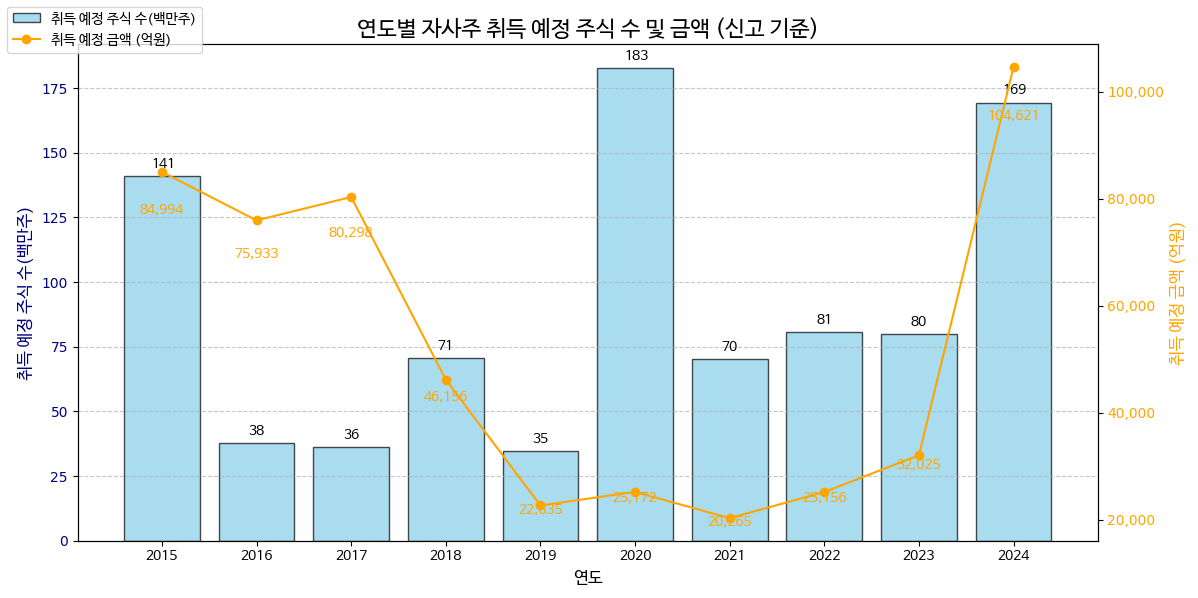

In [43]:
# 연도별 취득예정주식(주) 및 취득예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '취득예정주식': 'sum',
    '취득예정금액': 'sum'
})

# 단위 변환
annual_summary['취득예정주식'] = annual_summary['취득예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['취득예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='취득 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['취득예정금액'],
                 color='orange', marker='o', label='취득 예정 금액 (억원)')
ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['취득예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


### 금감원 공시에서 장내 vs 장외 구분자 달기

In [44]:
# 정규식 패턴 정의
pattern_mkt = re.compile(r'시장|장내|시간\s?외|거래소')  # '시간 외'와 '시간외'를 모두 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method(method):
    if pattern_mkt.search(method) and not pattern_otc_exclude.search(method):
        return 'mkt'
    else:
        return 'otc'

# 새로운 열에 카테고리 할당
df_dart_buyback['method'] = df_dart_buyback['취득방법'].apply(categorize_method)

### 금감원 공시에서 시간외대량매매 구분자 달기

In [45]:
# 정규식 패턴 정의 |
pattern_blockdeal = re.compile(r'대량|시간\s?외')  # 대량, 시간외가 있으면 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method_blockdeal(method):
    if pattern_blockdeal.search(method) and not pattern_otc_exclude.search(method):
        return 'blockdeal'
    else:
        return 'not_bd'

# 새로운 열에 카테고리 할당
df_dart_buyback['blockdeal'] = df_dart_buyback['취득방법'].apply(categorize_method_blockdeal)

# 확인해보기
df_dart_buyback[df_dart_buyback['blockdeal'] ==  'blockdeal']

,회사명,접수일,취득예정주식,취득예정금액,취득시작일,취득종료일,보유시작일,보유종료일,취득목적,취득방법,연도,method,blockdeal
98,우리금융지주,2024-03-13,9357960.0,1366.262160,2024-03-14,2024년 03월 14일,-,-,자기주식 취득 및 소각을 통한 주주가치 제고,시간외대량매매,2024,mkt,blockdeal
95,한화생명,2015-10-29,65139750.0,5202.711833,2015-10-28,2015년 10월 29일,-,-,주가 안정을 통한 주주가치 제고,시간외 대량매매,2015,mkt,blockdeal


2015년부터 2024년 사이에 자사주 매입을 '시간외대량매매'방식으로 한 경우는 두 번이었습니다. **우리금융지주**와 **한화생명**이었네요. 둘다 공통적으로 **예금보험공사**로부터 사들이는 경우였습니다.
<br>
따라서 이러한 특수한 경우를 제외하고는, **자사주 매입을 시간외대량매매로 하는 경우는 사실상 없다고 봐도 되겠습니다.**

<br>

![woori]({{site.url}}/assets/images/2025-02-15-blockdeal/woori.png)
<br>

![hanhwa]({{site.url}}/assets/images/2025-02-15-blockdeal/hanhwa.png)

혹시 모르니, '취득방법'으로 기재한 내용 전체를 확인해 볼까요? 시간외대량매매에 해당하는 내용은 정말 두 케이스 밖에 없는 것 같습니다.

In [46]:
sorted(df_dart_buyback['취득방법'].unique())

['-',
 '거래소 유가증권시장을 통한 매수',
 '공개매수',
 '무상 수증',
 '무상수증',
 '시간외 대량매매',
 '시간외대량매매',
 '유가시장을 통한 직접 취득',
 '유가증권 시장을 통한 장내 매수',
 '유가증권 시장을 통한 장내 직접 취득',
 '유가증권 시장을 통한 장내매매',
 '유가증권 시장을 통한 장내매수',
 '유가증권 시장을 통한 직접 매수',
 '유가증권 시장을 통한 직접 취득',
 '유가증권 시장을 통한 직접취득',
 '유가증권시장 장내매수',
 '유가증권시장에서 장내매수',
 '유가증권시장에서의 장내직접취득',
 '유가증권시장에서의 직접 취득',
 '유가증권시장에서의 취득',
 '유가증권시장을 통한 매수',
 '유가증권시장을 통한 장내 매수',
 '유가증권시장을 통한 장내 직접 취득',
 '유가증권시장을 통한 장내 직접매수',
 '유가증권시장을 통한 장내 직접취득',
 '유가증권시장을 통한 장내매수',
 '유가증권시장을 통한 장내매수 (직접취득)',
 '유가증권시장을 통한 장내매수(장중취득)',
 '유가증권시장을 통한 장내매수(직접 취득)',
 '유가증권시장을 통한 장내매수(직접취득)',
 '유가증권시장을 통한 장내직접취득',
 '유가증권시장을 통한 직접 취득',
 '유가증권시장을 통한 직접취득',
 '유가증권시장을 통한장내매수',
 '유가증권을 통한 장내매수',
 '자본시장법 등 관계법령에서 정한 방법에 따라 장내 매수',
 '장내 매수',
 '장내 직접 매수',
 '장내 직접 취득',
 '장내 직접취득',
 '장내매수',
 '장내매수(직접취득)',
 '장내취득',
 '장외 직접 거래',
 '장외 직접 매수',
 '장외 취득',
 '장외매수',
 '장외직접매수',
 '장외취득',
 '장외회수(직접취득)',
 '증권시장 장내 직접취득',
 '증권시장 장내취득',
 '증권시장에서 장내취득',
 '증권시장에서의 장내 직접취득',
 '증권시장에서의 취득',
 '증권시장을 통한 장내매수',
 '증권시장을 통한 직접취득',
 '증여'

## 코스닥 시장에서 시간외대량매매 방식으로 자사주 매입 사례를 찾기

### 금감원 공시에서 자사주 데이터 수집하기

In [21]:
# 사용자 입력 받기
start_y = "2015"
end_y = "2024"
corp_type_input = "코"

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11332" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11332',
 'corpType': 'A'}

처음 크롤링은 페이지 인덱스 1을 기준으로 한다. 첫번째 페이지를 크롤링 했을 때, 그 결과물에는 전체 페이지가 얼마나 되는지 정보가 포함되어 있다. 따라서 첫번째 페이지 크롤링 결과물에서 페이지가 2이상인 것으로 확인되는 경우 추가로 크롤링을 수행한다.

우선 첫번째 페이지의 크롤링을 수행한다.

In [22]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)

# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

첫번째 페이지의 크롤링 결과물에서 전체 페이지 수를 확인하고, 페이지가 2이상일 경우 페이지 수만큼 Loop을 통해 크롤링 수행한다.

In [23]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 8
total_counts: 800


*   확인한 페이지 개수대로 loop 돌리기



In [24]:
for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  #데이터프레임 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

데이터를 모두 수집하여 데이터프레임으로 만들었다. 다운받은 데이터프레임의 칼럼이 현재 3단계로 되어있는데, 분석의 편의성을 위해 칼럼을 1단계로 축소하고 단위를 변환(원 → 억원)한다.

In [25]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns]

In [26]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_buyback.columns = ['회사명', '접수일',
                           '취득예정주식(주)_보통주식', '취득예정주식(주)_기타주식',
                           '취득예정금액(원)_보통주식', '취득예정금액(원)_기타주식',
                           '취득예상기간_시작일','취득예상기간_종료일',
                           '보유예상기간_시작일','보유예상기간_종료일',
                           '취득목적', '취득방법', '위탁투자중개업자',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_보통주식',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%)',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_기타주식',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%).1',
                           '취득 전 자기주식 보유현황_기타취득(주)_보통주식',
                           '취득 전 자기주식 보유현황_기타취득(주)_비율(%)',
                           '취득 전 자기주식 보유현황_기타취득(주)_기타주식',
                           '취득 전 자기주식 보유현황_기타취득(주)_비율(%).1',
                           '취득결정일',
                           '사외이사참석여부_참석(명)', '사외이사참석여부_불참(명)',
                           '감사 (사외이사가 아닌 감사위원) 참석여부',
                           '1일 매수 주문수량 한도_보통주식', '1일 매수 주문수량 한도_기타주식',
                           '비고']

# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_buyback = df_dart_buyback[['회사명', '접수일',
                           '취득예정주식(주)_보통주식',
                           '취득예정금액(원)_보통주식',
                           '취득예상기간_시작일','취득예상기간_종료일',
                           '보유예상기간_시작일','보유예상기간_종료일',
                           '취득목적', '취득방법']].copy()

df_dart_buyback.columns = ['회사명', '접수일',
                           '취득예정주식','취득예정금액','취득시작일','취득종료일',
                           '보유시작일','보유종료일','취득목적', '취득방법']

In [27]:
# 기존에는 접수일을 datetime으로 변환 및 연도 추출하였으나,
# 공시가 정정될 경우, 연도가 바뀌는 이슈가 있었음
# 그리하여 연도의 기준은 '취득예상기간의 시작일'로 설정함

#다트 편집기를 보면 날짜를 입력하는 형태는 두가지가 있다
#(1) 2022.08.03
#(2) 2022년 08월 03일
#따라서 두번째 형태일 경우 첫번째 형태로 전환하는 함수를 생성한다
def chg_date_format(date_input) :
    if '년' in date_input:
        new_year = date_input[0:4]
        new_month = date_input[6:8]
        new_day = date_input[10:12]
        new_date = new_year + new_month + new_day
    else :
        new_date = date_input
    return new_date

#생성한 함수를 통해서 포맷을 바꿔준다
df_dart_buyback['취득시작일'] = df_dart_buyback.취득시작일.apply(lambda x : chg_date_format(x))
df_dart_buyback['취득시작일'] = pd.to_datetime(df_dart_buyback['취득시작일'], errors='coerce')
df_dart_buyback['연도'] = df_dart_buyback['취득시작일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액'] = pd.to_numeric(
    df_dart_buyback['취득예정금액'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback['회사명'] = df_dart_buyback['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)


### 금감원 공시 기준 데이터 시각화

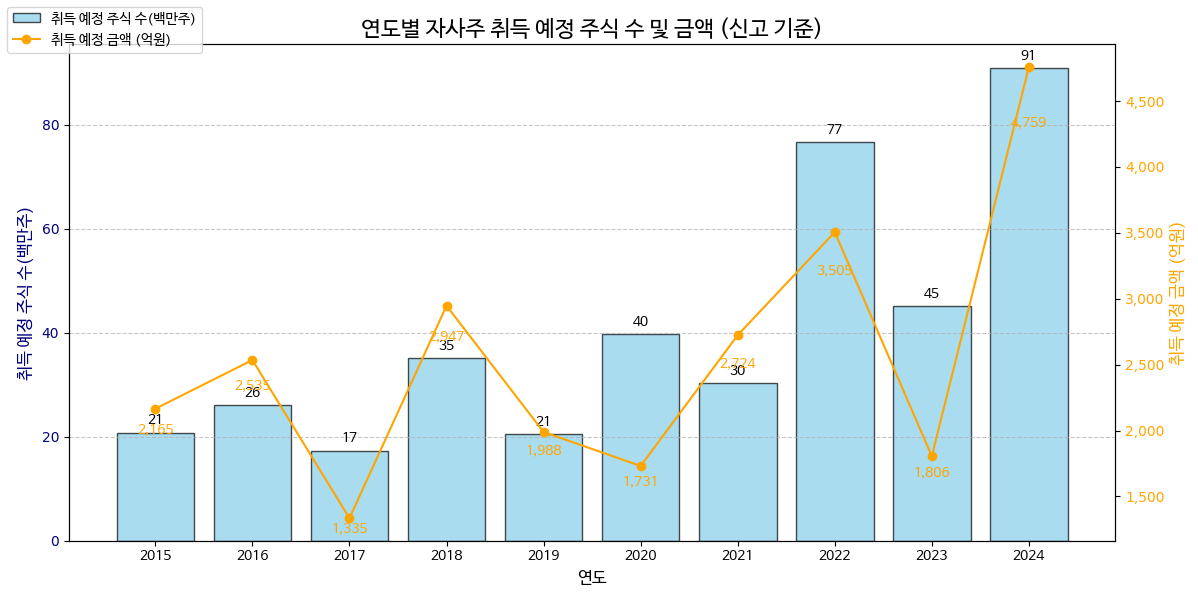

In [28]:
# 연도별 취득예정주식(주) 및 취득예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '취득예정주식': 'sum',
    '취득예정금액': 'sum'
})

# 단위 변환
annual_summary['취득예정주식'] = annual_summary['취득예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['취득예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='취득 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['취득예정금액'],
                 color='orange', marker='o', label='취득 예정 금액 (억원)')
ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['취득예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


### 금감원 공시에서 장내 vs 장외 구분자 달기

In [29]:
# 정규식 패턴 정의
pattern_mkt = re.compile(r'시장|장내|시간\s?외|거래소')  # '시간 외'와 '시간외'를 모두 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method(method):
    if pattern_mkt.search(method) and not pattern_otc_exclude.search(method):
        return 'mkt'
    else:
        return 'otc'

# 새로운 열에 카테고리 할당
df_dart_buyback['method'] = df_dart_buyback['취득방법'].apply(categorize_method)

### 금감원 공시에서 시간외대량매매 구분자 달기

In [ ]:
# 정규식 패턴 정의 |대량|시간\s?외
pattern_blockdeal = re.compile(r'대량|시간\s?외')  # 대량, 시간외가 있으면 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method_blockdeal(method):
    if pattern_blockdeal.search(method) and not pattern_otc_exclude.search(method):
        return 'blockdeal'
    else:
        return 'not_bd'

# 새로운 열에 카테고리 할당
df_dart_buyback['blockdeal'] = df_dart_buyback['취득방법'].apply(categorize_method_blockdeal)

# 확인해보기
df_dart_buyback[df_dart_buyback['blockdeal'] ==  'blockdeal']

코스닥의 경우에는 2015~2024년 동안 시간외대량매매로 자사주 매입을 한 경우가 한번도 없었습니다. 코스피와 코스닥을 통틀어 '시간외대량매매'방식을 통한 자사주 매입은 사실상 없다고 봐도 될 것같습니다.<br>
<br>
코스피와 마찬가지로, 코스닥에서도 상장사가 기재한 '취득방법'을 전부 확인해보도록 하겠습니다. 시간외대량매매가 없습니다.

In [35]:
sorted(df_dart_buyback['취득방법'].unique())

['-',
 'KOSDAQ 시장에서 직접 취득',
 '계좌이체',
 '공개매수',
 '기타 장외매수',
 '기타취득',
 '당사 직접취득',
 '당사자 사이의 상환전환우선주 계약에 의한 매수(장외매수)',
 '당사자간 계약에 의한 직접매수',
 '대물상환계약에 따른 실물인수',
 '무상 수증',
 '무상 증여',
 '무상수증',
 '상환우선주 및 우선주 보유주주로 부터 장외 직접 매수',
 '상환우선주 보유주주로 부터 장외 직접매수',
 '상환전환우선주 보유주주로 부터 장외 직접 매수',
 '상환전환우선주 보유주주로부터 장외 직접 매수',
 '상환전환우선주식을 보유한 우선주주로부터 상환청구통지 수령 및 상환대금 납입',
 '실물 취득',
 '유가증권 시장을 통한 직접 취득',
 '유가증권시장을 통한 장내 매수',
 '장내',
 '장내 매수',
 '장내 직접 취득',
 '장내 직접취득',
 '장내 취득',
 '장내매매',
 '장내매수',
 '장내매수 (직접취득)',
 '장내매수(직접 취득)',
 '장내매수(직접취득)',
 '장내매수방식',
 '장내직접취득',
 '장내취득',
 '장외 직접 매수',
 '장외 취득(계좌간 대체)',
 '장외매수',
 '장외직접매수',
 '장외취득',
 '전환상환우선주 보유주주로부터 직접매수',
 '전환우선주 보유주주로 부터 장외 직접 매수',
 '증권계좌 대체로 장외 직접취득',
 '증권시장 내 장내취득',
 '증권시장 장내 직접취득',
 '증권시장내 매수',
 '증권시장내 직접 취득',
 '증권시장에서 장내 취득',
 '증권시장에서 장내취득',
 '증권시장에서 직접 취득',
 '증권시장에서 취득',
 '증권시장에서의 장내취득',
 '증권시장에서의 취득',
 '증권시장을 통한 장내 직접 취득',
 '증권시장을 통한 장내 직접취득',
 '증권시장을 통한 직접취득',
 '질권말소 후 입고',
 '최대주주로부터 무상수증',
 '코넥스시장을 통한 장내 직접취득',
 '코스닥 시장 장내 매수',
 '코스닥 시장 장내 직접 취득',
 '코스닥

다음 포스팅에서는 자사주 처분의 경우를 확인해보도록 하겠습니다.